In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

station = pd.read_csv("./094/station.csv", sep='\t', engine="python")
patient = pd.read_csv("./094/patient.csv", sep='\t', engine="python")
observation = pd.read_csv("./094/observation.csv", sep='\t', engine="python")

print("patient.shape =", patient.shape)
print("station.shape =", station.shape)
print("observation.shape =", observation.shape)

patient.shape = (2102, 13)
station.shape = (798, 6)
observation.shape = (12081, 23)


In [ ]:
# (A-1b)
print("patient columns:", patient.columns.tolist())
print("station columns:", station.columns.tolist())
print("observation columns:", observation.columns.tolist())

#### 🩺 Súbor patient.csv
- **Počet záznamov:** 2 102  
- **Počet atribútov:** 13  
- **Typy dát:** object = 10, int64 = 2, float64 = 1  
- **Chýbajúce hodnoty:** spolu ≈ 3 993  
  - Najviac chýba: `residence` (100 %), `job` (70 %), `address` (15 %), `current_location` (5 %).  
- **Charakteristika:** obsahuje demografické údaje pacientov a odkaz na stanicu (`station_ID`).  
  Tento odkaz sa **nedá priamo spárovať** s názvom v `súbore station.csv`.  

#### ⚙️ Súbor station.csv
- **Počet záznamov:** 798  
- **Počet atribútov:** 6  
- **Typy dát:** object = 4, float64 = 2  
- **Chýbajúce hodnoty:** 0  
- **Charakteristika:** obsahuje informácie o meracích staniciach – `station`, `latitude`, `longitude`, `QoS`, `revision`, `location`.  
- **Pozorovanie:** hodnoty `revision` majú rôzne formáty dátumov (a časť nevieme správne parsovať) → potrebná normalizácia na jednotný formát `datetime`.

#### 📊 Súbor observation.csv
- **Počet záznamov:** 12 081  
- **Počet atribútov:** 23  
- **Typy dát:** všetky `float64`  
- **Chýbajúce hodnoty:** 0  
- **Cieľová premenná:** `oximetry` (binárna 0/1).  
- **Dôležité atribúty:** `SpO₂`, `HR`, `Skin Temperature`, `BP`, `CO`, `FiO₂`, atď.  
- Hodnoty SpO₂ sú v rozsahu 95 – 100 a Skin Temperature v rozsahu 33 – 38 °C.  
- Tieto dáta majú vhodný formát pre ďalšie spracovanie v Python/pandas a na trénovanie modelov.


In [22]:
def dtype_counts(df): 
    return df.dtypes.astype(str).value_counts().to_dict()

summ = {
    "patient": {
        "shape": patient.shape,
        "dtype_counts": dtype_counts(patient),
        "missing_total": int(patient.isna().sum().sum())
    },
    "station": {
        "shape": station.shape,
        "dtype_counts": dtype_counts(station),
        "missing_total": int(station.isna().sum().sum())
    },
    "observation": {
        "shape": observation.shape,
        "dtype_counts": dtype_counts(observation),
        "missing_total": int(observation.isna().sum().sum())
    }
}
summ


{'patient': {'shape': (2102, 13),
  'dtype_counts': {'string': 8,
   'Int64': 3,
   'category': 1,
   'datetime64[ns, UTC]': 1},
  'missing_total': 3993},
 'station': {'shape': (798, 6),
  'dtype_counts': {'Float64': 2,
   'string': 2,
   'datetime64[ns, UTC]': 1,
   'category': 1},
  'missing_total': 0},
 'observation': {'shape': (12081, 23),
  'dtype_counts': {'Float64': 22, 'Int64': 1},
  'missing_total': 0}}

#### Analýza chýbajúcich hodnôt (EDA)


In [ ]:
missing_pct = (patient.isna().sum() / len(patient) * 100).round(2).sort_values(ascending=False)
missing_pct.head(10)

#### Z výpočtu percenta chýbajúcich hodnôt vidíme, že niektoré atribúty obsahujú výrazný počet prázdnych záznamov:

#### Atribút	Podiel chýbajúcich hodnôt
residence	100 %
job	≈ 70 %
address	≈ 15 %
current_location	≈ 5 %

#### 🔗 Vzťahy medzi súbormi
| Vzťah | Typ väzby | Popis |
|:--|:--:|:--|
| observation ↔ station | 1 : N | Každé meranie má priradenú stanicu (100 % zhoda cez `latitude`, `longitude`). |
| patient ↔ station | ? | Nepodarilo sa spárovať cez `current_location`, zhoda 0 %. |
| patient ↔ observation | – | Chýba priame prepojenie (pacient ID v meraniach neexistuje). |

In [ ]:
sta_lat = pd.to_numeric(station["latitude"], errors="coerce").round(4)
sta_lon = pd.to_numeric(station["longitude"], errors="coerce").round(4)
obs_lat = pd.to_numeric(observation["latitude"], errors="coerce").round(4)
obs_lon = pd.to_numeric(observation["longitude"], errors="coerce").round(4)

station_key = set(zip(sta_lat, sta_lon))
obs_key = list(zip(obs_lat, obs_lon))

obs_valid = sum([not (pd.isna(k[0]) or pd.isna(k[1])) for k in obs_key])
obs_match = sum([(k in station_key) for k in obs_key if not (pd.isna(k[0]) or pd.isna(k[1]))])

print(f"observation → station match by coords: {obs_match}/{obs_valid} ({obs_match/obs_valid:.3f})")

# patient ↔ station:
import re
def parse_current_location(s):
    if not isinstance(s, str): 
        return (np.nan, np.nan)
    nums = re.findall(r"Decimal\\('([-+]?\\d*\\.?\\d+)'\\)", s)
    return (float(nums[0]), float(nums[1])) if len(nums)==2 else (np.nan, np.nan)

latlon = patient["current_location"].apply(parse_current_location)
pat_lat = pd.to_numeric([t[0] for t in latlon], errors="coerce").round(4)
pat_lon = pd.to_numeric([t[1] for t in latlon], errors="coerce").round(4)

pat_valid = np.isfinite(pat_lat).sum()
pat_match = sum([(k in station_key) for k in zip(pat_lat, pat_lon) if not (pd.isna(k[0]) or pd.isna(k[1]))])

print(f"patient → station match by coords: {pat_match}/{pat_valid} ({(pat_match/pat_valid if pat_valid else 0):.3f})")


#### 📈 Vizualizácia (EDA)
Histogramy rozloženia hodnôt:
- **SpO₂** → zväčša v rozmedzí 97 – 99 %  
- **Skin Temperature** → rozloženie 33 – 38 °C s vrcholom okolo 36 °C  

Tieto vizualizácie potvrdzujú, že dáta majú správny a očakávaný fyzio-rozsah.


In [ ]:

# 1) SpO2
plt.figure()
observation["SpO₂"].hist(bins=30, edgecolor="black")
plt.title("Rozloženie SpO₂")
plt.xlabel("SpO₂")
plt.ylabel("Frekvencia")
plt.show()

# 2) Skin Temperature
plt.figure()
observation["Skin Temperature"].hist(bins=30, edgecolor="black")
plt.title("Rozloženie Skin Temperature")
plt.xlabel("°C")
plt.ylabel("Frekvencia")
plt.show()


### 🧩 Zhrnutie zistení
- Dáta majú zrozumiteľnú štruktúru a sú v správnom formáte na ďalšie spracovanie.  
- Najviac problémov má `súbor patient.csv` → mnoho chýbajúcich hodnôt.  
- `súbor station.csv` má nekonzistentné formáty v atribúte `revision`.  
- `súbor observation.csv` je čistý a vhodný na modelovanie (strojové učenie).  
- Vzťah `observation` ↔ `station` funguje perfektne, ale prepojenie pacientov chýba.  


# (C-1)

In [ ]:
numeric = observation.select_dtypes(include=['number'])

corr = numeric.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelačná matica fyziologických atribútov (observation.csv)")
plt.show()

### Interpretácia výsledkov párovej analýzy dát

Z korelačnej matice (obrázok vyššie) je možné identifikovať viacero významných vzťahov medzi fyziologickými atribútmi:

- **CO a HR (r = 0.76)** – veľmi silná pozitívna korelácia, ktorá zodpovedá očakávanej závislosti medzi srdcovou frekvenciou a srdcovým výdajom.  
- **PVI a Blood Flow Index (r = 0.67)** – silný vzťah medzi variabilitou perfúzie a prietokom krvi.  
- **Oximetry a PVI (r = 0.67)** – saturácia kyslíkom úzko súvisí s variabilitou perfúzie.  
- **Skin Temperature a PI (r = −0.49)** – negatívna korelácia; s rastúcou teplotou kože klesá perfúzny index.  
- **Skin Temperature a Oximetry (r = 0.37)** – mierna pozitívna závislosť, naznačuje možné prepojenie medzi periférnou teplotou a saturáciou.  
- Väčšina ostatných atribútov (napr. `latitude`, `longitude`, `SNR`, `PRV`) nevykazuje štatisticky významné lineárne vzťahy.

Tieto zistenia poukazujú na fyziologické súvislosti medzi vybranými premennými
a pomáhajú určiť, ktoré atribúty môžu byť relevantné pri budúcom modelovaní
a predikcii cieľovej premennej `oximetry`.


In [ ]:
corr_pairs = corr.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[(corr_pairs < 0.999) & (corr_pairs > -0.999)]
print("🔝 Top 10 korelácií medzi atribútmi:\n")
print(corr_pairs.head(10))

In [ ]:
pairs_to_plot = [
    ("CO", "HR"),
    ("oximetry", "PVI"),
    ("Skin Temperature", "oximetry"),
]

for x, y in pairs_to_plot:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=observation, x=x, y=y, alpha=0.6)
    plt.title(f"Vzťah medzi {x} a {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

### Interpretácia výsledkov

Top 10 korelácií ukazuje, že:

- **CO a HR (r = 0.76)** – silná lineárna závislosť, vyššia srdcová frekvencia znamená väčší srdcový výdaj.  
- **Oximetry a PVI (r = 0.67)** – saturácia kyslíkom úzko súvisí s variabilitou perfúzie.  
- **Skin Temperature a Oximetry (r = 0.37)** – mierna pozitívna korelácia, naznačuje vplyv periférnej teploty na saturáciu.  
- **EtCO₂ a PI (r = 0.31)** – slabší, ale viditeľný pozitívny vzťah.  

Tieto výsledky naznačujú, ktoré premenné môžu mať najväčší význam pri budúcej predikcii
cieľovej premennej `oximetry`.


# (b - 2)

In [18]:
import re

ranges = pd.read_csv("./094/sensor_variable_range.csv", sep="\t")
print(ranges.head())

def parse_range(r):
    nums = re.findall(r"[\d\.]+", str(r))
    if len(nums) >= 2:
        return float(nums[0]), float(nums[1])
    else:
        return None, None
    
ranges[["Min", "Max"]] = ranges["Value Range"].apply(lambda r: pd.Series(parse_range(r)))
ranges = ranges.dropna(subset=["Min", "Max"])
ranges.loc[ranges["Variable"] == "BP", ["Min", "Max"]] = [90.0, 120.0]
print(ranges[["Variable", "Min", "Max"]])

  Variable         Unit                     Description        Value Range
0     SpO₂            %    Peripheral oxygen saturation            95–100%
1       HR          bpm  Heart rate from pulse oximeter         60–100 bpm
2       PI            %                 Perfusion index            0.2–20%
3       RR  breaths/min                Respiratory rate  12–20 breaths/min
4    EtCO₂         mmHg        End-tidal carbon dioxide         35–45 mmHg
                Variable   Min    Max
0                   SpO₂  95.0  100.0
1                     HR  60.0  100.0
2                     PI   0.2   20.0
3                     RR  12.0   20.0
4                  EtCO₂  35.0   45.0
5                   FiO₂  21.0  100.0
6                    PRV  20.0  200.0
7                     BP  90.0  120.0
8       Skin Temperature  33.0   38.0
10                   PVI  10.0   20.0
11              Hb level  12.0   18.0
12                    SV  60.0  100.0
13                    CO   4.0    8.0
16  Signal Quality

In [19]:
anomalies = []

for _, row in ranges.iterrows():
    var = row["Variable"]
    low, high = row["Min"], row["Max"]
    
    if var in observation.columns:
        invalid = observation[(observation[var] < low) | (observation[var] > high)]
        anomalies.append({
            "Atribút": var,
            "Počet abnormálnych hodnôt": len(invalid),
            "Min povolené": low,
            "Max povolené": high
        })

anomalies_df = pd.DataFrame(anomalies)
anomalies_df

,Atribút,Počet abnormálnych hodnôt,Min povolené,Max povolené
0,SpO₂,0,95.0,100.0
1,HR,0,60.0,100.0
2,PI,0,0.2,20.0
3,RR,0,12.0,20.0
4,EtCO₂,0,35.0,45.0
5,FiO₂,0,21.0,100.0
6,PRV,0,20.0,200.0
7,BP,0,90.0,120.0
8,Skin Temperature,0,33.0,38.0
9,PVI,0,10.0,20.0


### B-2b Kontrola správnosti v dátach

Dáta z *observation.csv* boli porovnané s referenčnými rozsahmi fyziologických parametrov zo *sensor_variable_range.csv*.  
V žiadnom z atribútov neboli zistené abnormálne hodnoty mimo definovaných intervalov,  
čo naznačuje, že dataset neobsahuje chybné alebo extrémne merania.  

Pre istotu bola ďalej vykonaná kontrola nelogických kombinácií hodnôt
(vzťahov medzi atribútmi), ktoré by mohli naznačovať chyby senzora alebo anotácie.

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


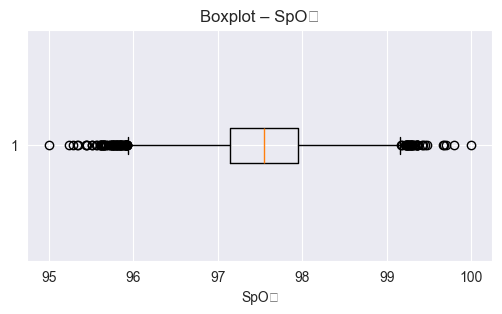

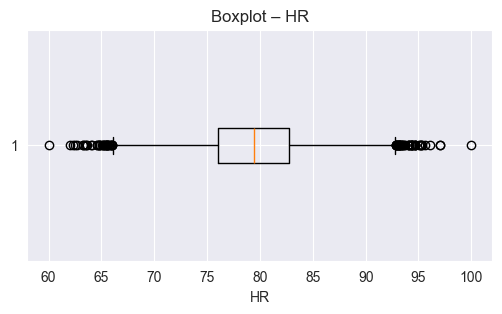

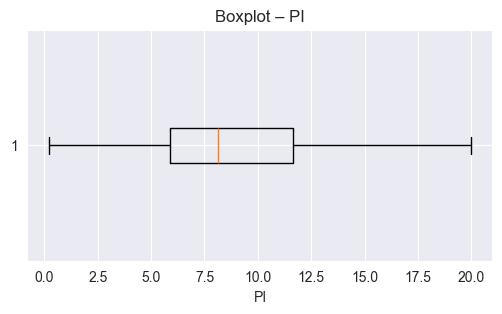

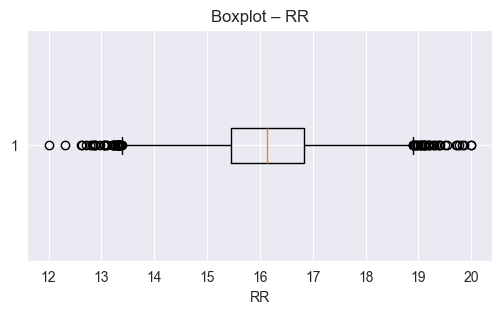

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


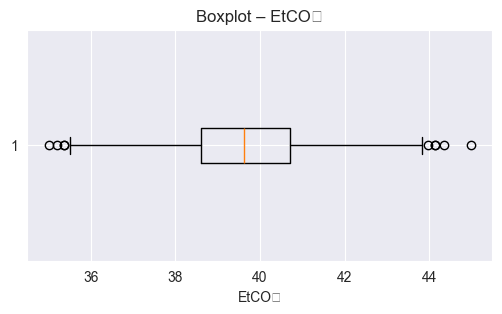

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


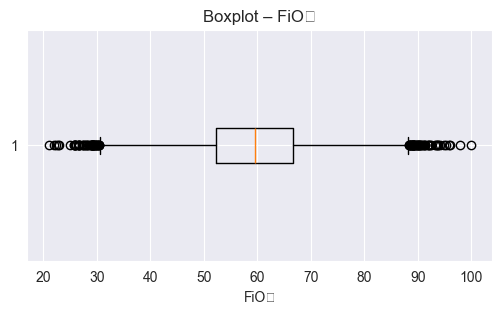

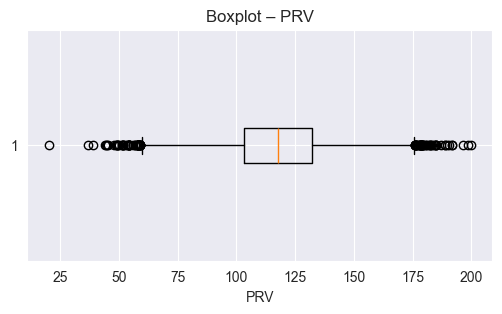

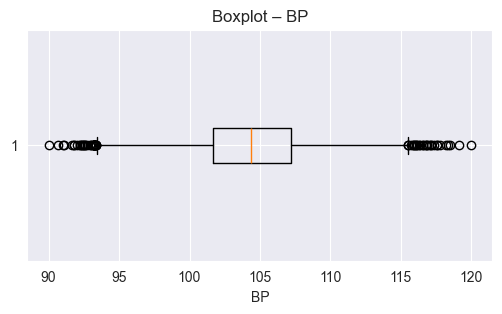

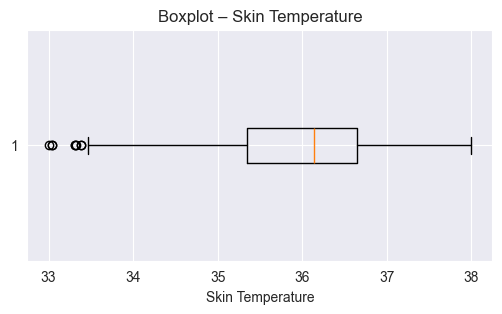

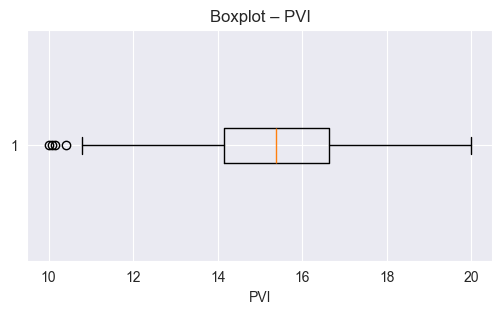

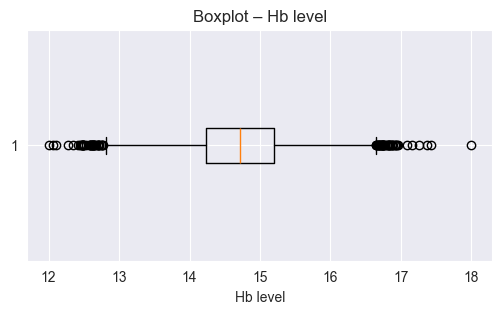

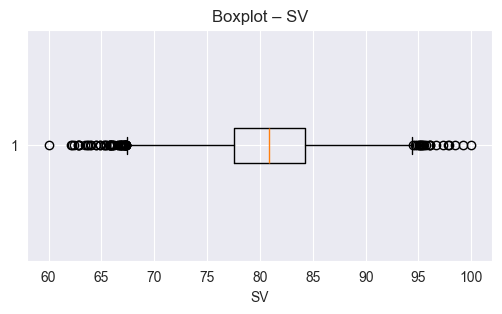

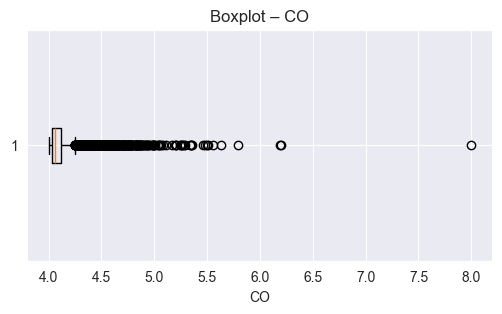

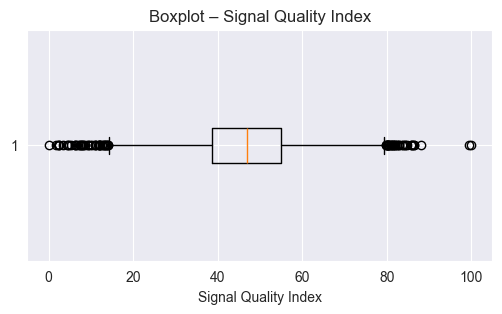

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


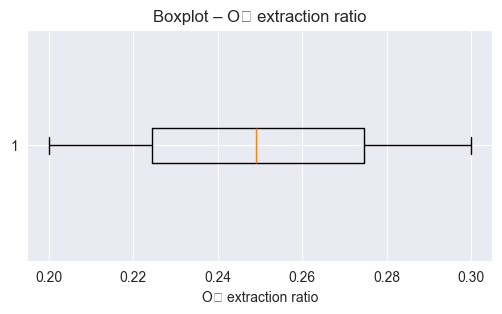

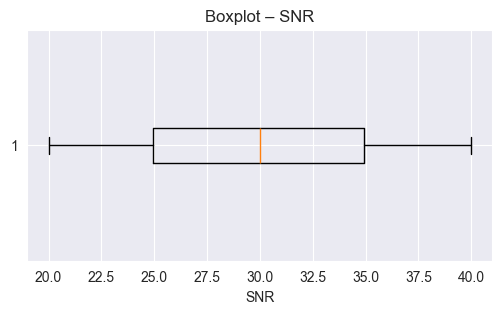

In [20]:
import matplotlib.pyplot as plt

for var in ranges["Variable"]:
    if var in observation.columns:
        plt.figure(figsize=(6,3))
        plt.boxplot(observation[var].dropna(), vert=False)
        plt.title(f"Boxplot – {var}")
        plt.xlabel(var)
        plt.show()

#### Ci obsahujú nelogické dátové vzťahy, ktoré sú následkom dátovej kolekcie a anotovania dát   

In [21]:
logic_errors = []

# 1️⃣ Давление = 0 при наличии пульса — сенсорная ошибка
if "BP" in observation.columns and "HR" in observation.columns:
    mask = (observation["BP"] == 0) & (observation["HR"] > 0)
    logic_errors.append(("BP = 0 a HR > 0", mask.sum()))

# 2️⃣ Проверка согласованности сердечного выброса: CO ≈ HR × SV / 1000
if all(col in observation.columns for col in ["CO", "HR", "SV"]):
    co_est = observation["HR"] * observation["SV"] / 1000.0
    mask = (observation["CO"] - co_est).abs() > 0.5 * co_est.fillna(0).abs()
    logic_errors.append(("|CO - HR*SV/1000| > 30%", mask.sum()))

# 3️⃣ Высокое качество сигнала, но низкий SNR — нелогично
if "Signal Quality Index" in observation.columns and "SNR" in observation.columns:
    mask = (observation["Signal Quality Index"] >= 80) & (observation["SNR"] < 20)
    logic_errors.append(("Signal Quality Index ≥ 80 a SNR < 20", mask.sum()))

# 4️⃣ Низкое качество сигнала, но идеальная SpO₂ — подозрительно
if "Signal Quality Index" in observation.columns and "SpO₂" in observation.columns:
    mask = (observation["Signal Quality Index"] <= 10) & (observation["SpO₂"] >= 99)
    logic_errors.append(("Signal Quality Index ≤ 10 a SpO₂ ≥ 99", mask.sum()))

# 5️⃣ Комнатный кислород (FiO₂ ≈ 21%), но низкая SpO₂ — возможная ошибка
if "FiO₂" in observation.columns and "SpO₂" in observation.columns:
    mask = (observation["FiO₂"] <= 22) & (observation["SpO₂"] < 85)
    logic_errors.append(("FiO₂ ≈ 21% a SpO₂ < 85%", mask.sum()))

# 6️⃣ Геокоординаты вне допустимого диапазона
if "latitude" in observation.columns and "longitude" in observation.columns:
    mask = (
        observation["latitude"].lt(-90)
        | observation["latitude"].gt(90)
        | observation["longitude"].lt(-180)
        | observation["longitude"].gt(180)
    )
    logic_errors.append(("Latitude/Longitude mimo rozsah", mask.sum()))

# 7️⃣ Бонус: RR и EtCO₂ не должны расходиться более чем на порядок
if "RR" in observation.columns and "EtCO₂" in observation.columns:
    mask = (observation["RR"] > 40) & (observation["EtCO₂"] < 20)
    logic_errors.append(("RR > 40 a EtCO₂ < 20", mask.sum()))

logic_df = pd.DataFrame(logic_errors, columns=["Podmienka", "Počet porušení"])
logic_df

,Podmienka,Počet porušení
0,BP = 0 a HR > 0,0
1,|CO - HR*SV/1000| > 30%,0
2,Signal Quality Index ≥ 80 a SNR < 20,0
3,Signal Quality Index ≤ 10 a SpO₂ ≥ 99,0
4,FiO₂ ≈ 21% a SpO₂ < 85%,0
5,Latitude/Longitude mimo rozsah,0
6,RR > 40 a EtCO₂ < 20,0


### B-2b Kontrola správnosti v dátach

Na základe referenčných rozsahov zo súboru *sensor_variable_range.csv* bola vykonaná kontrola správnosti hodnôt v datasete *observation.csv*.

- Neboli zistené žiadne **abnormálne hodnoty** mimo povolených fyziologických intervalov.
- Následne bola vykonaná aj **kontrola logických vzťahov** medzi atribútmi:
  - `BP = 0 a HR > 0`
  - `|CO – HR×SV/1000| > 30 %`
  - `Signal Quality Index ≥ 80 a SNR < 20`
  - `Signal Quality Index ≤ 10 a SpO₂ ≥ 99`
  - `FiO₂ ≈ 21 % a SpO₂ < 85 %`
  - `Latitude/Longitude mimo rozsah`
  - `RR > 40 a EtCO₂ < 20`

Všetky podmienky mali **0 porušení**, čo znamená, že dataset neobsahuje nelogické alebo chybné kombinácie údajov.  
Dáta sú teda **konzistentné, bez anomálií** a vhodné na ďalšiu fázu projektu – analýzu vzťahov (C-1) a modelovanie cieľovej premennej `oximetry`.
